In [19]:
from difference_models import BinaryDifferenceClassifier, MulticlassDifferenceClassifier
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pickle
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import util
%matplotlib inline

In [3]:
with open('dataset.pickle', 'rb') as f:
    X, y, feature_names, n_features, n_samples = pickle.load(f)
with open('classifiers.pickle', 'rb') as f:
    clf_a, clf_b = pickle.load(f)

### Differences of predicted labels

First, let's see to what extent the predicted labels are different:

In [4]:
binary_diff_clf = BinaryDifferenceClassifier(clf_a, clf_b)
binary_diff_clf.fit(X, y)
is_pred_equal = binary_diff_clf.predict(X)
proba_diff = binary_diff_clf.predict_proba(X)[:, 0]

In [5]:
np.sum(is_pred_equal)

130

In [6]:
is_pred_diff = ~is_pred_equal
np.sum(is_pred_diff)

20

Let's investigate the predicted labels in more detail, using adapted classical tools for classification evaluation:

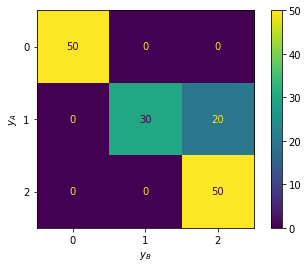

In [11]:
pred_a = clf_a.predict(X)
pred_b = clf_b.predict(X)
cm = confusion_matrix(pred_a, pred_b, labels=clf_a.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_a.classes_)
fig, ax = plt.subplots()
disp.plot(ax=ax)
ax.set_ylabel('$y_A$')
ax.set_xlabel('$y_B$')
plt.show()

What are the predicted probabilities for these instances?

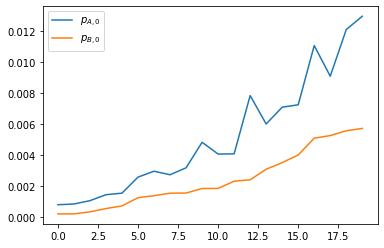

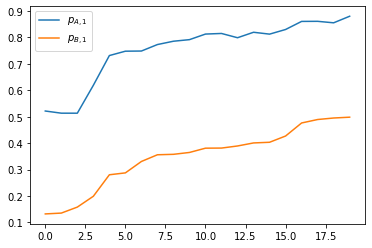

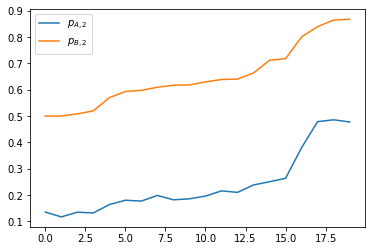

In [16]:
proba_a = clf_a.predict_proba(X)
proba_b = clf_b.predict_proba(X)
for class_idx, (proba_a_, proba_b_) in enumerate(zip(proba_a.T, proba_b.T)):
    order = np.argsort(proba_b_[is_pred_diff])
    plt.plot(proba_a_[is_pred_diff][order], label=f'$p_{{A,{class_idx}}}$')
    plt.plot(proba_b_[is_pred_diff][order], label=f'$p_{{B,{class_idx}}}$')
    plt.legend()
    plt.show()

And in margin space (log-odds probabilities):

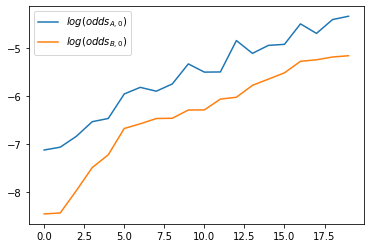

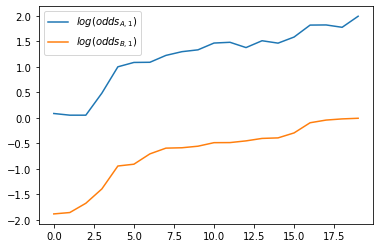

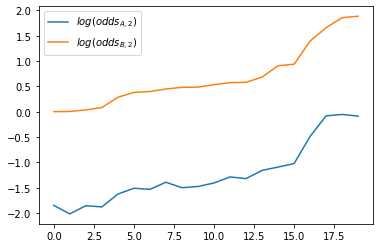

In [21]:
log_odds_a = util.calc_log_odds_from_log_proba(clf_a.predict_log_proba(X))
log_odds_b = util.calc_log_odds_from_log_proba(clf_b.predict_log_proba(X))
for class_idx, (log_odds_a_, log_odds_b_) in enumerate(zip(log_odds_a.T, log_odds_b.T)):
    order = np.argsort(log_odds_b_[is_pred_diff])
    plt.plot(log_odds_a_[is_pred_diff][order], label=f'$log(odds_{{A,{class_idx}}})$')
    plt.plot(log_odds_b_[is_pred_diff][order], label=f'$log(odds_{{B,{class_idx}}})$')
    plt.legend()
    plt.show()

### Differences of probabilities

In [22]:
diff_clf = MulticlassDifferenceClassifier(clf_a, clf_b)
diff_clf.fit(X, y)
pred = diff_clf.predict(X)
proba = diff_clf.predict_proba(X)

Let's check the distributions of the probabilities for each class:

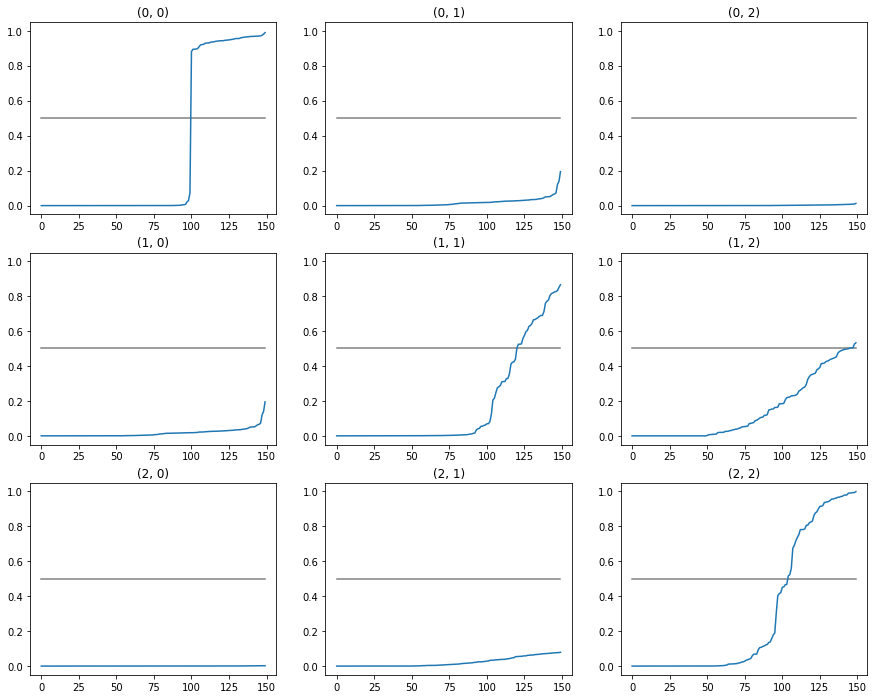

In [55]:
nrows = len(diff_clf.base_classes)
ncols = len(diff_clf.base_classes)
fig = plt.figure(figsize=(ncols*5, nrows*4))
ax_ref = None
for plot_idx, (class_proba, class_tuple) in enumerate(zip(proba.T, diff_clf.class_tuples), 1):
    ax = fig.add_subplot(nrows, ncols, plot_idx, sharey=ax_ref)
    if not ax_ref:
        ax_ref = ax
    ax.plot(np.repeat(0.5, class_proba.shape[0]), c='grey')
    ax.plot(np.sort(class_proba), label=str(class_tuple))
    ax.set_title(str(class_tuple))

Scatter plot of the probabilities for the difference classes, with a color for each class:

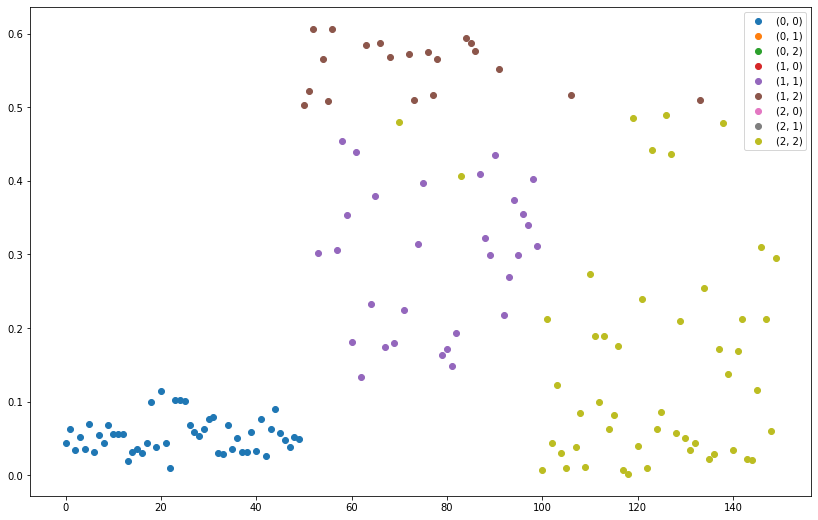

In [26]:
indices = np.indices(y.shape).ravel()
fig, ax = plt.subplots(figsize=(14, 9))
for class_ in diff_clf.classes_:
    mask = pred == class_
    ax.scatter(indices[mask], proba_diff[mask], label=str(diff_clf.class_tuples[class_]))
ax.legend()
plt.show()

Euclidian distance between pairs of probabilities $|p_B - p_A|$:

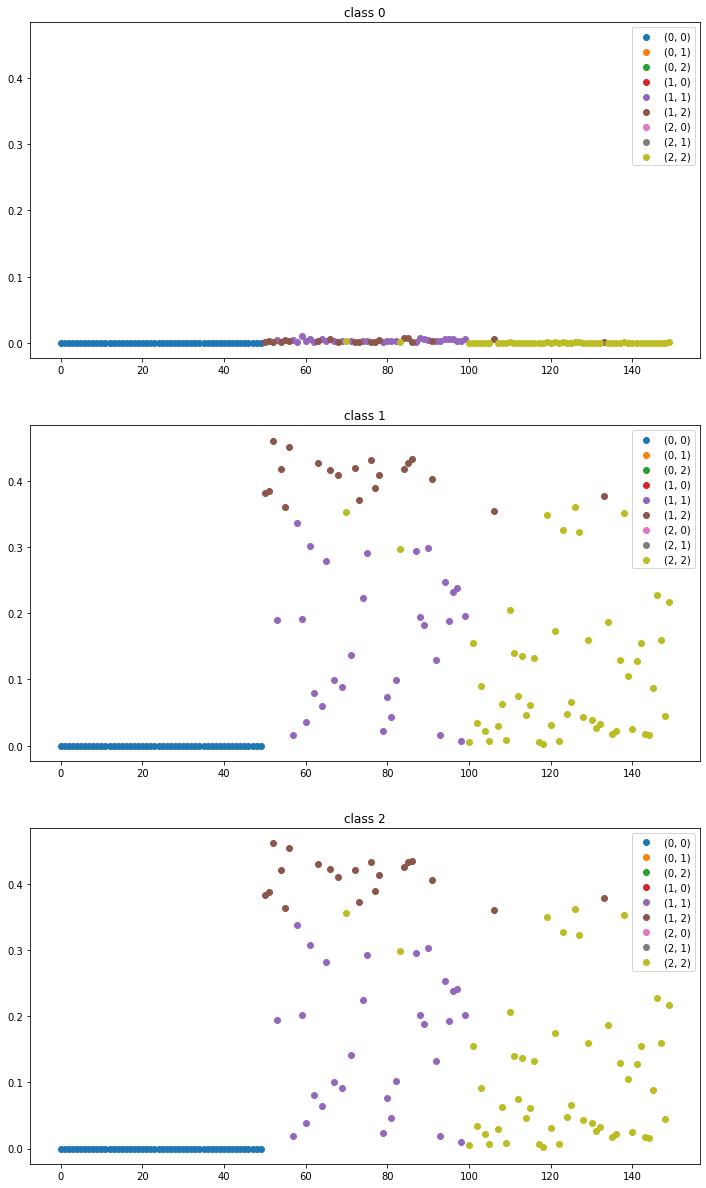

In [43]:
nrows = len(clf_a.classes_)
ncols = 1
fig = plt.figure(figsize=(12*ncols, 7*nrows))
ax_ref = None
for class_idx, (proba_a_, proba_b_) in enumerate(zip(proba_a.T, proba_b.T)):
    dist = np.abs(proba_b_ - proba_a_)
    ax = fig.add_subplot(nrows, ncols, class_idx + 1, sharey=ax_ref)
    if not ax_ref:
        ax_ref = ax
    for class_ in diff_clf.classes_:
        mask = pred == class_
        ax.scatter(indices[mask], dist[mask], label=str(diff_clf.class_tuples[class_]))
    ax.legend()
    ax.set_title(f'class {class_idx}')
plt.show()

And further subtractions:

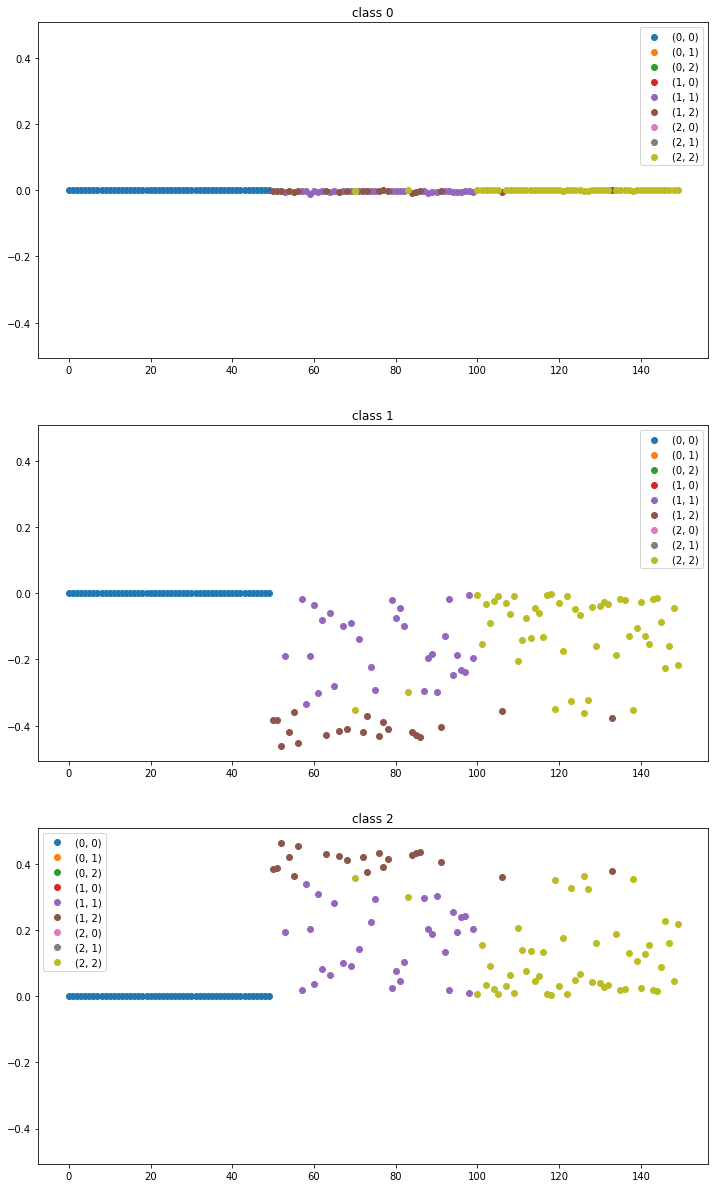

In [42]:
nrows = len(clf_a.classes_)
ncols = 1
fig = plt.figure(figsize=(12*ncols, 7*nrows))
ax_ref = None
for class_idx, (proba_a_, proba_b_) in enumerate(zip(proba_a.T, proba_b.T)):
    dist = proba_b_ - proba_a_
    ax = fig.add_subplot(nrows, ncols, class_idx + 1, sharey=ax_ref)
    if not ax_ref:
        ax_ref = ax
    for class_ in diff_clf.classes_:
        mask = pred == class_
        ax.scatter(indices[mask], dist[mask], label=str(diff_clf.class_tuples[class_]))
    ax.legend()
    ax.set_title(f'class {class_idx}')
plt.show()

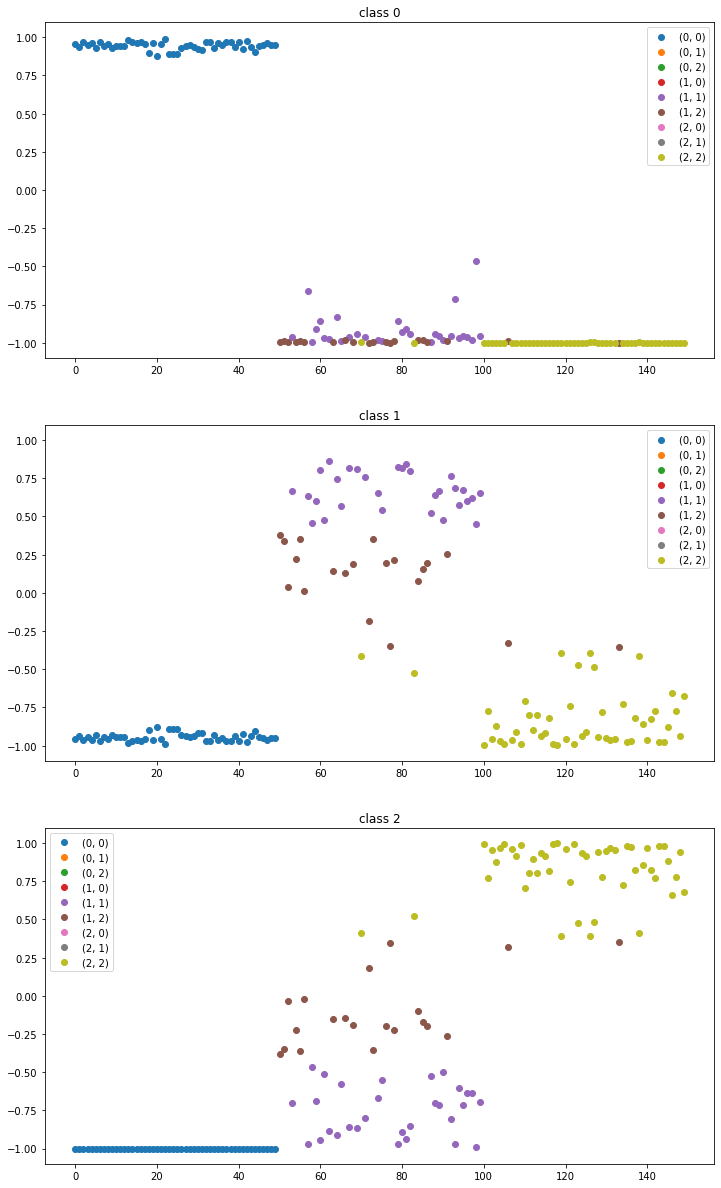

In [41]:
nrows = len(clf_a.classes_)
ncols = 1
fig = plt.figure(figsize=(12*ncols, 7*nrows))
ax_ref = None
for class_idx, (proba_a_, proba_b_) in enumerate(zip(proba_a.T, proba_b.T)):
    dist = proba_b_ - (1-proba_a_)
    ax = fig.add_subplot(nrows, ncols, class_idx + 1, sharey=ax_ref)
    if not ax_ref:
        ax_ref = ax
    for class_ in diff_clf.classes_:
        mask = pred == class_
        ax.scatter(indices[mask], dist[mask], label=str(diff_clf.class_tuples[class_]))
    ax.legend()
    ax.set_title(f'class {class_idx}')
plt.show()

[Here](https://en.wikipedia.org/wiki/Metric_space#Examples_of_metric_spaces) is another distance function proposed $|log(\frac{p_B}{p_A})|$ that forms a complete metric space for real positive numbers

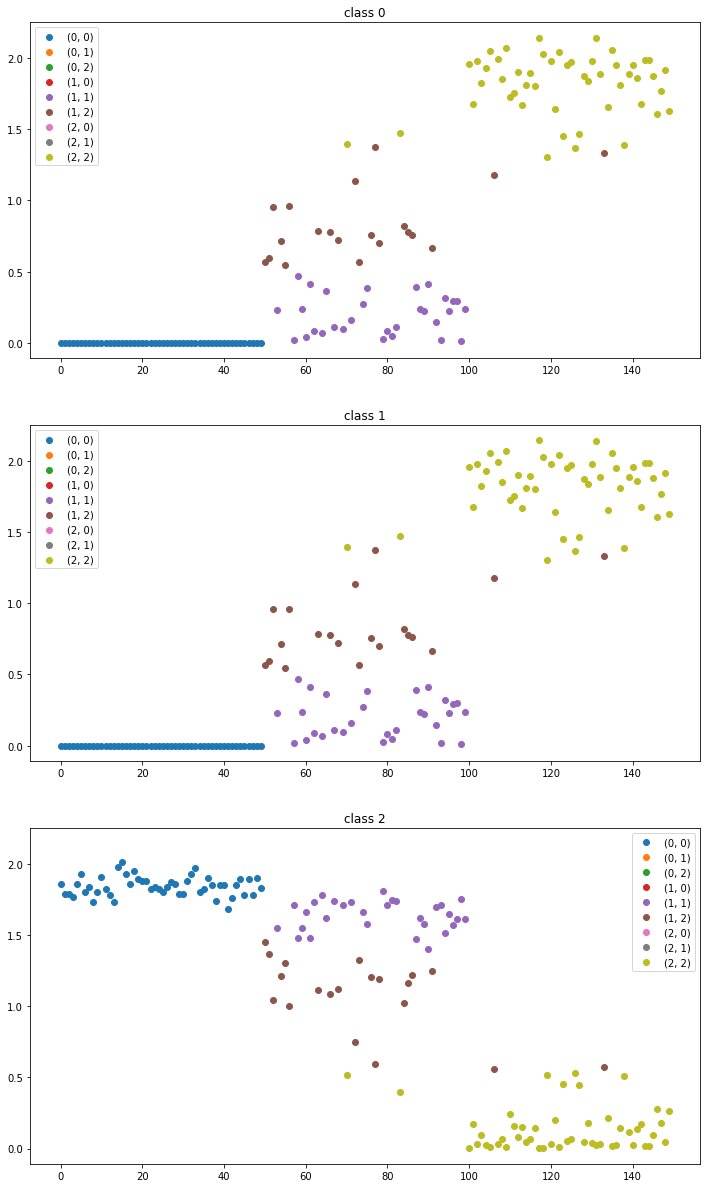

In [44]:
nrows = len(clf_a.classes_)
ncols = 1
fig = plt.figure(figsize=(12*ncols, 7*nrows))
ax_ref = None
for class_idx, (proba_a_, proba_b_) in enumerate(zip(proba_a.T, proba_b.T)):
    dist = np.abs(np.log(proba_b_/proba_a_))
    ax = fig.add_subplot(nrows, ncols, class_idx + 1, sharey=ax_ref)
    if not ax_ref:
        ax_ref = ax
    for class_ in diff_clf.classes_:
        mask = pred == class_
        ax.scatter(indices[mask], dist[mask], label=str(diff_clf.class_tuples[class_]))
    ax.legend()
    ax.set_title(f'class {class_idx}')
plt.show()

### Differences of log odds
Now let's see how that looks like in margin space

In [46]:
log_odds_equal = util.calc_binary_log_odds_from_log_proba(binary_diff_clf.predict_log_proba(X))
log_odds = util.calc_log_odds_from_log_proba(diff_clf.predict_log_proba(X))

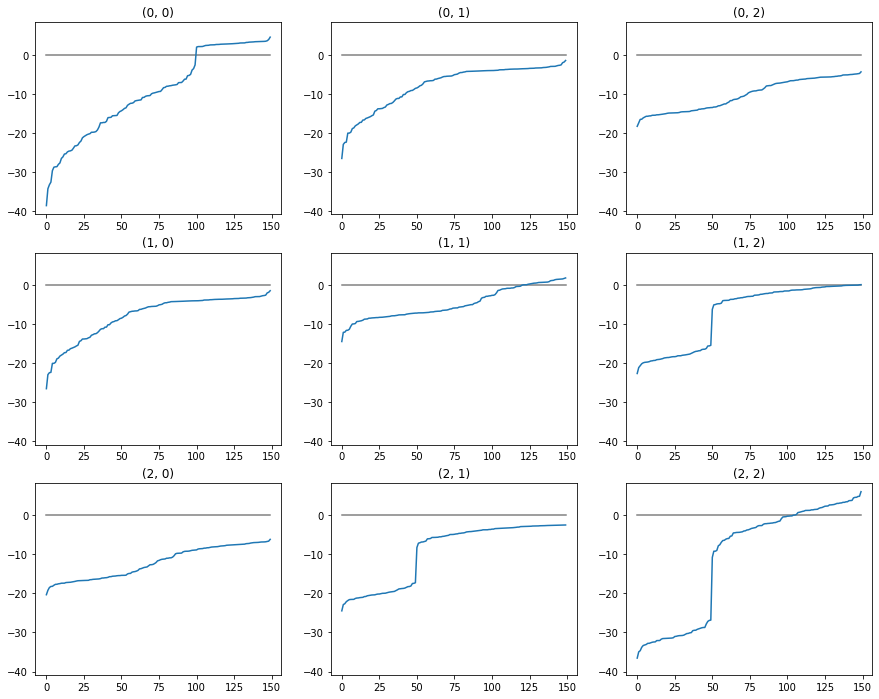

In [53]:
nrows = len(diff_clf.base_classes)
ncols = len(diff_clf.base_classes)
fig = plt.figure(figsize=(ncols*5, nrows*4))
ax_ref = None
for plot_idx, (class_log_odds, class_tuple) in enumerate(zip(log_odds.T, diff_clf.class_tuples), 1):
    ax = fig.add_subplot(nrows, ncols, plot_idx, sharey=ax_ref)
    if not ax_ref:
        ax_ref = ax
    ax.plot(np.repeat(0, class_log_odds.shape[0]), c='grey')
    ax.plot(np.sort(class_log_odds), label=str(class_tuple))
    ax.set_title(str(class_tuple))

Scatter plot of the log-odds for the difference classes, with a color for each class:

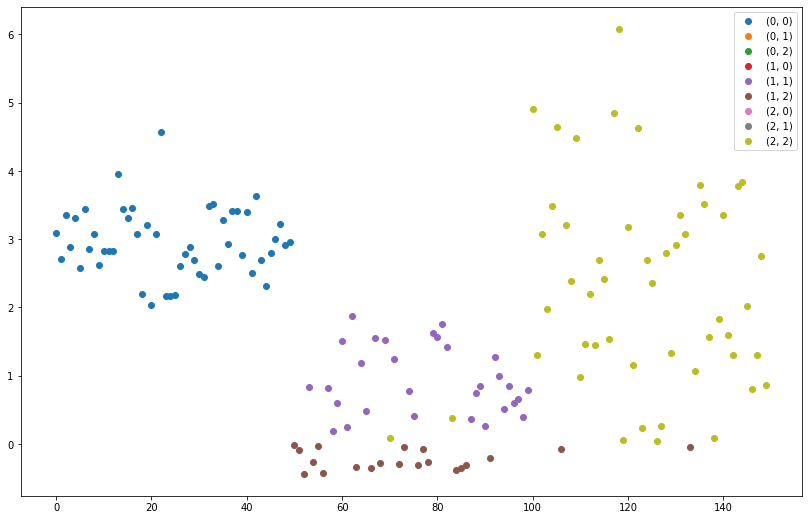

In [56]:
indices = np.indices(y.shape).ravel()
fig, ax = plt.subplots(figsize=(14, 9))
for class_ in diff_clf.classes_:
    mask = pred == class_
    ax.scatter(indices[mask], log_odds_equal[mask], label=str(diff_clf.class_tuples[class_]))
ax.legend()
plt.show()

Euclidian distance between pairs of log-odds $|log(odds(B) - log(odds(A))|$:

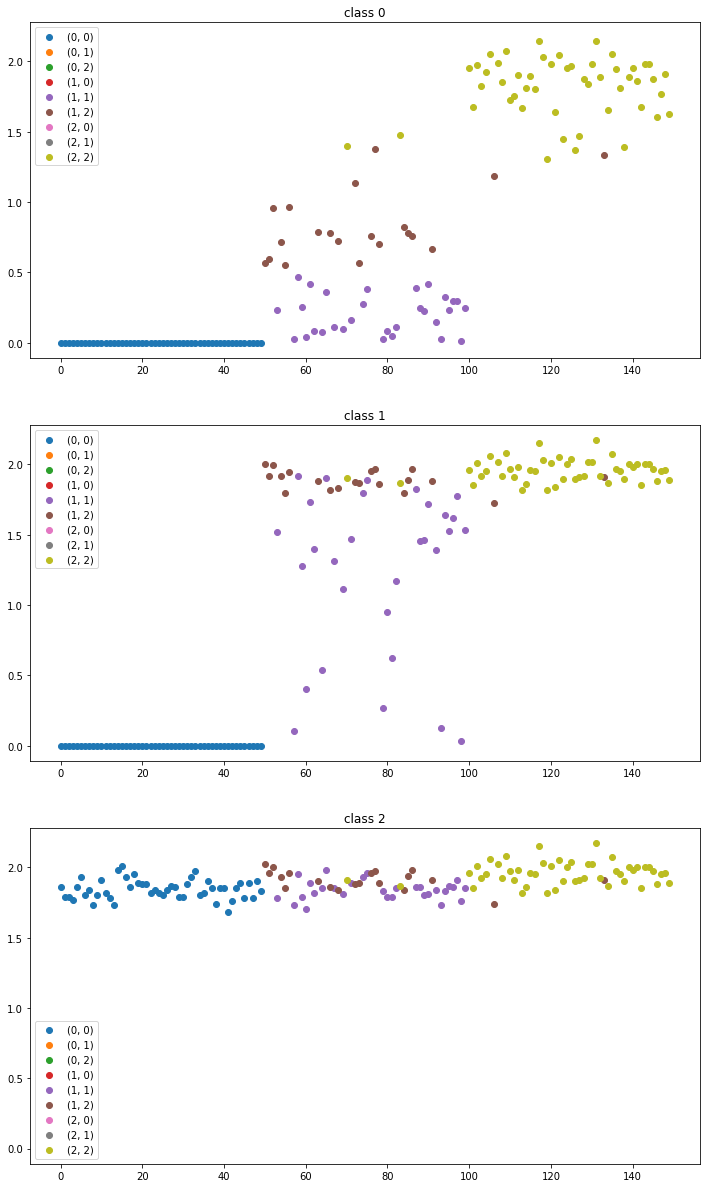

In [57]:
nrows = len(clf_a.classes_)
ncols = 1
fig = plt.figure(figsize=(12*ncols, 7*nrows))
ax_ref = None
for class_idx, (log_odds_a_, log_odds_b_) in enumerate(zip(log_odds_a.T, log_odds_b.T)):
    dist = np.abs(log_odds_b_ - log_odds_a_)
    ax = fig.add_subplot(nrows, ncols, class_idx + 1, sharey=ax_ref)
    if not ax_ref:
        ax_ref = ax
    for class_ in diff_clf.classes_:
        mask = pred == class_
        ax.scatter(indices[mask], dist[mask], label=str(diff_clf.class_tuples[class_]))
    ax.legend()
    ax.set_title(f'class {class_idx}')
plt.show()

Log-odds-ratio

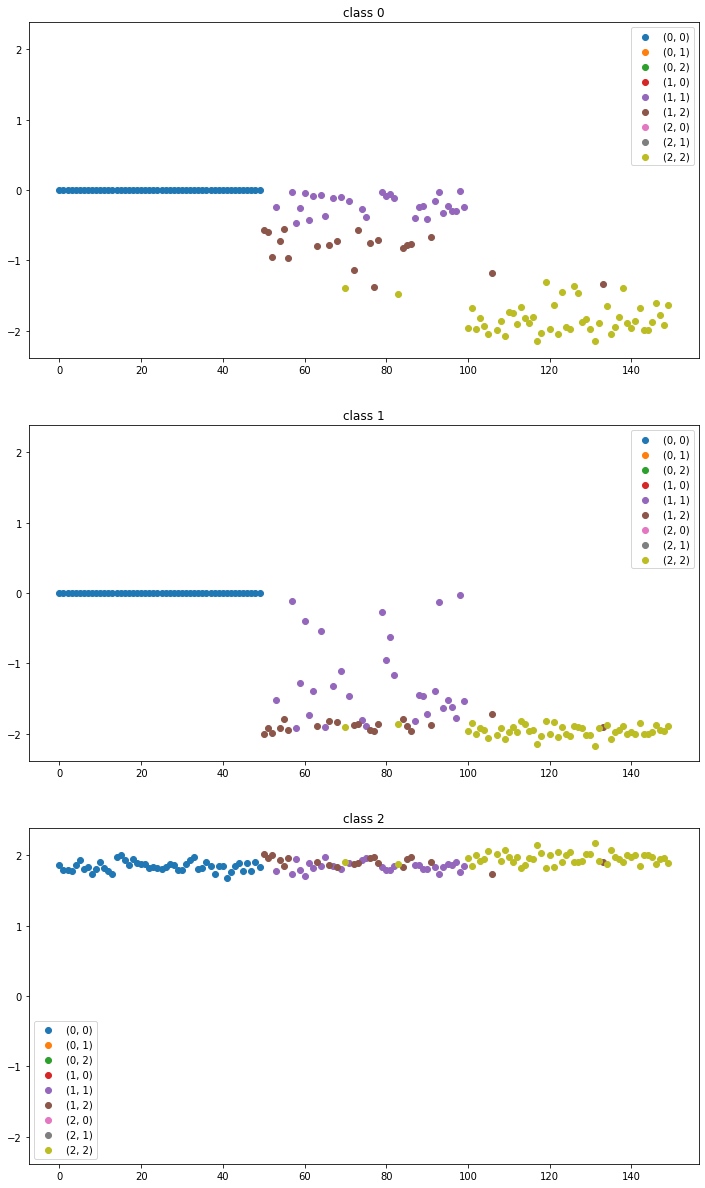

In [58]:
nrows = len(clf_a.classes_)
ncols = 1
fig = plt.figure(figsize=(12*ncols, 7*nrows))
ax_ref = None
for class_idx, (log_odds_a_, log_odds_b_) in enumerate(zip(log_odds_a.T, log_odds_b.T)):
    dist = log_odds_b_ - log_odds_a_
    ax = fig.add_subplot(nrows, ncols, class_idx + 1, sharey=ax_ref)
    if not ax_ref:
        ax_ref = ax
    for class_ in diff_clf.classes_:
        mask = pred == class_
        ax.scatter(indices[mask], dist[mask], label=str(diff_clf.class_tuples[class_]))
    ax.legend()
    ax.set_title(f'class {class_idx}')
plt.show()